In [25]:
import sys 
print(sys.executable)

/Users/ammarmahmood/Documents/Data Science Resources/technical_interviews/Haensel/.myenv/bin/python


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import pymc as pm
import arviz as az
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from scipy.signal import find_peaks
import graphviz
import pytensor.tensor as at

from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv("data/MMM_test_data.csv")

In [3]:
df.head(7)

,start_of_week,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
0,30-08-20,157906.75,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79
1,06-09-20,186425.68,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45
2,13-09-20,161607.39,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05
3,20-09-20,180089.13,1690.70,52.79,15185.22,3883.41,15521.41,12890.22,24728.73
4,27-09-20,217793.98,1547.30,80.56,18524.05,4043.09,15793.74,12642.55,26515.48
5,04-10-20,195581.04,3655.19,525.06,18024.45,9739.47,20804.05,25445.63,30394.41
6,11-10-20,146951.61,6459.43,640.94,24012.09,7048.24,33009.65,33692.83,37544.71


In [4]:
df.dtypes

start_of_week       object
revenue            float64
spend_channel_1    float64
spend_channel_2    float64
spend_channel_3    float64
spend_channel_4    float64
spend_channel_5    float64
spend_channel_6    float64
spend_channel_7    float64
dtype: object

In [5]:
df.columns

Index(['start_of_week', 'revenue', 'spend_channel_1', 'spend_channel_2',
       'spend_channel_3', 'spend_channel_4', 'spend_channel_5',
       'spend_channel_6', 'spend_channel_7'],
      dtype='object')

In [6]:
total_revenue = df["revenue"].sum(axis=0)
total_spend = (df.loc[:,"spend_channel_1":"spend_channel_7"].sum(axis=0)).sum()
print(f"Total Revenue: {total_revenue:.0f}")
print(f"Total Spend: {total_spend:.0f}")
print(f"ROAS (Total Revenue / Total Spend): {total_revenue/total_spend:.3f}")

Total Revenue: 14194980
Total Spend: 7212633
ROAS (Total Revenue / Total Spend): 1.968


In [7]:
df.describe()

,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,136490.190673,1245.604808,343.640962,19507.177981,6915.136731,8575.611442,5063.699038,27701.367404
std,50810.253012,1388.384632,332.988218,8714.759886,3123.172035,6956.787524,6689.472660,12176.293684
min,63207.090000,0.000000,4.370000,5938.130000,3602.200000,747.460000,0.000000,9391.210000
25%,101675.685000,334.275000,120.470000,13879.000000,5113.937500,2902.032500,0.000000,19797.710000
50%,128790.460000,856.870000,202.020000,17929.450000,6194.400000,6879.270000,2423.095000,24248.640000
75%,157707.280000,1658.032500,553.075000,22252.262500,7470.557500,14367.582500,8701.960000,33852.652500
max,418186.380000,8513.830000,1605.850000,49689.380000,22629.690000,33009.650000,33692.830000,77488.420000


In [8]:
df_1 = df.copy()
df_1['start_of_week'] = pd.to_datetime(
    df_1['start_of_week'], format='%d-%m-%y'
)
df_1 = df_1.set_index(df_1['start_of_week'])

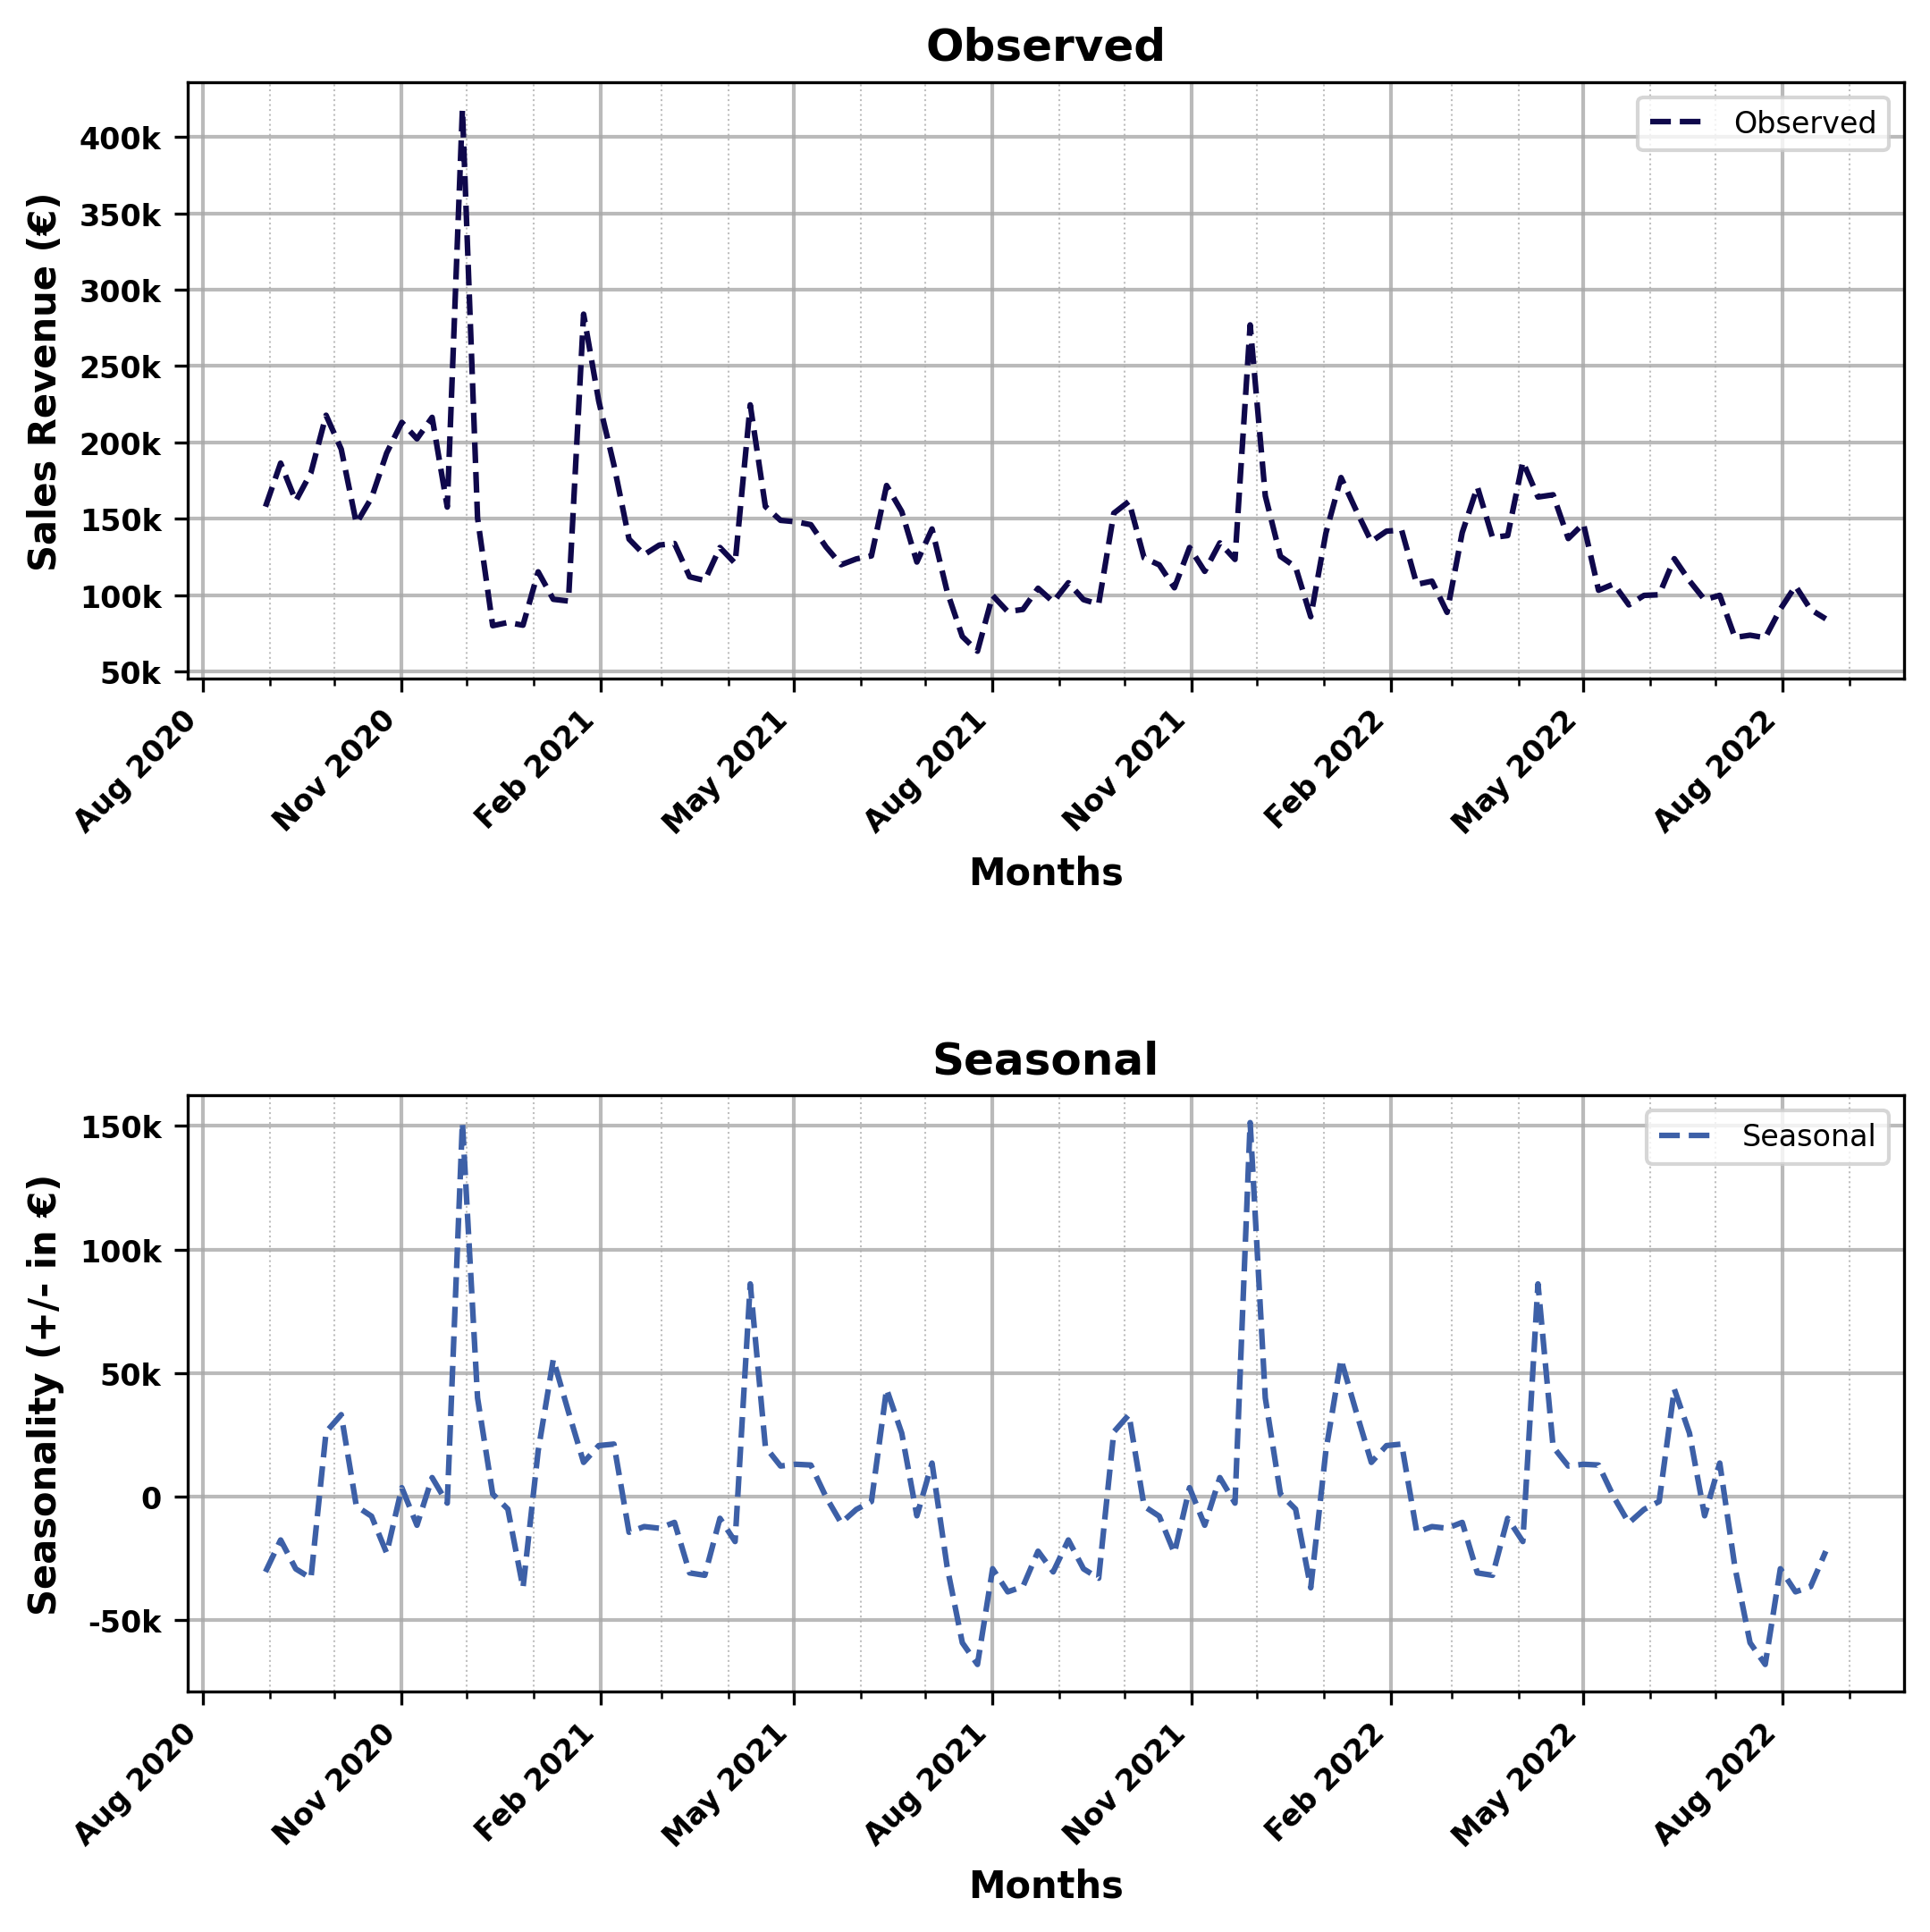

In [9]:
# Analyze Seasonality in Data

def thousands_formatter(x, pos):
    """
    Formatter function to convert large numbers to a 'k' format.
    E.g., 400000 becomes 400k.
    """
    if abs(x) >= 1000:
            return f'{int(x/1000)}k'
    return f'{int(x)}'

# Decompose the time series
decomposition = seasonal_decompose(
    pd.Series(df_1['revenue'], index=df_1['start_of_week']),
    model='additive',
    period=52
)

# Extract components
observed = decomposition.observed
seasonal = decomposition.seasonal

colors = {
        'observed': '#0F084B',
        'seasonal': '#3D60A7',
    }

# Define font properties
title_font = {'fontsize': 12, 'fontweight': 'bold'}
label_font = {'fontsize': 10, 'fontweight': 'bold'}
tick_fontsize = 8

# Define tick locator and formatter: major ticks every 3 months, minor ticks every month
major_locator = mdates.MonthLocator(interval=3)
major_formatter = mdates.DateFormatter('%b %Y')
minor_locator = mdates.MonthLocator(interval=1)

# axis locator
i = [0,1]

fig, ax = plt.subplots(2,1,figsize=(8, 8), dpi=300)
fig.patch.set_facecolor('white')

# -------------------------
# Plot for Observed Component
# -------------------------

ax[0].set_title('Observed', **title_font)
ax[0].set_xlabel('Months', **label_font)
ax[0].set_ylabel('Sales Revenue (€)', **label_font)

# Plot observed data with dashed line
ax[0].plot(observed.index, observed, linestyle='--', color=colors['observed'], label='Observed', linewidth=1.5)

# Set x-axis major and minor ticks
ax[0].xaxis.set_major_locator(major_locator)
ax[0].xaxis.set_major_formatter(major_formatter)
ax[0].xaxis.set_minor_locator(minor_locator)


# Format tick labels
plt.setp(ax[0].get_xticklabels(), rotation=45, ha='right', fontweight='bold', fontsize=tick_fontsize)
plt.setp(ax[0].get_yticklabels(), fontweight='bold', fontsize=tick_fontsize)

# Set custom y-axis formatter for thousands
ax[0].yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Add grid lines for major and minor ticks
ax[0].grid(which='major', linestyle='-', linewidth=1.0, color='darkgrey', alpha=0.8)
ax[0].grid(which='minor', linestyle=':', linewidth=0.5, color='grey', alpha=0.5)

ax[0].legend(fontsize=8)

# -------------------------
# Plot for Seasonal Component
# -------------------------

ax[1].set_title('Seasonal', **title_font)
ax[1].set_xlabel('Months', **label_font)
ax[1].set_ylabel('Seasonality (+/- in €)', **label_font)

# Plot seasonal data with dashed line
ax[1].plot(seasonal.index, seasonal, linestyle='--', color=colors['seasonal'], label='Seasonal', linewidth=1.5)

# Set x-axis major and minor ticks
ax[1].xaxis.set_major_locator(major_locator)
ax[1].xaxis.set_major_formatter(major_formatter)
ax[1].xaxis.set_minor_locator(minor_locator)

# Format tick labels
plt.setp(ax[1].get_xticklabels(), rotation=45, ha='right', fontweight='bold', fontsize=tick_fontsize)
plt.setp(ax[1].get_yticklabels(), fontweight='bold', fontsize=tick_fontsize)

# Set custom y-axis formatter for thousands
ax[1].yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Add grid lines for major and minor ticks
ax[1].grid(which='major', linestyle='-', linewidth=1.0, color='darkgrey', alpha=0.8)
ax[1].grid(which='minor', linestyle=':', linewidth=0.5, color='grey', alpha=0.5)

ax[1].legend(fontsize=8)

# Adjust layout: moderate spacing between subplots
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.15, hspace=0.7, wspace=0.1)

plt.show()
#plt.savefig("ObservedvsSeasonal.png")
plt.ion()

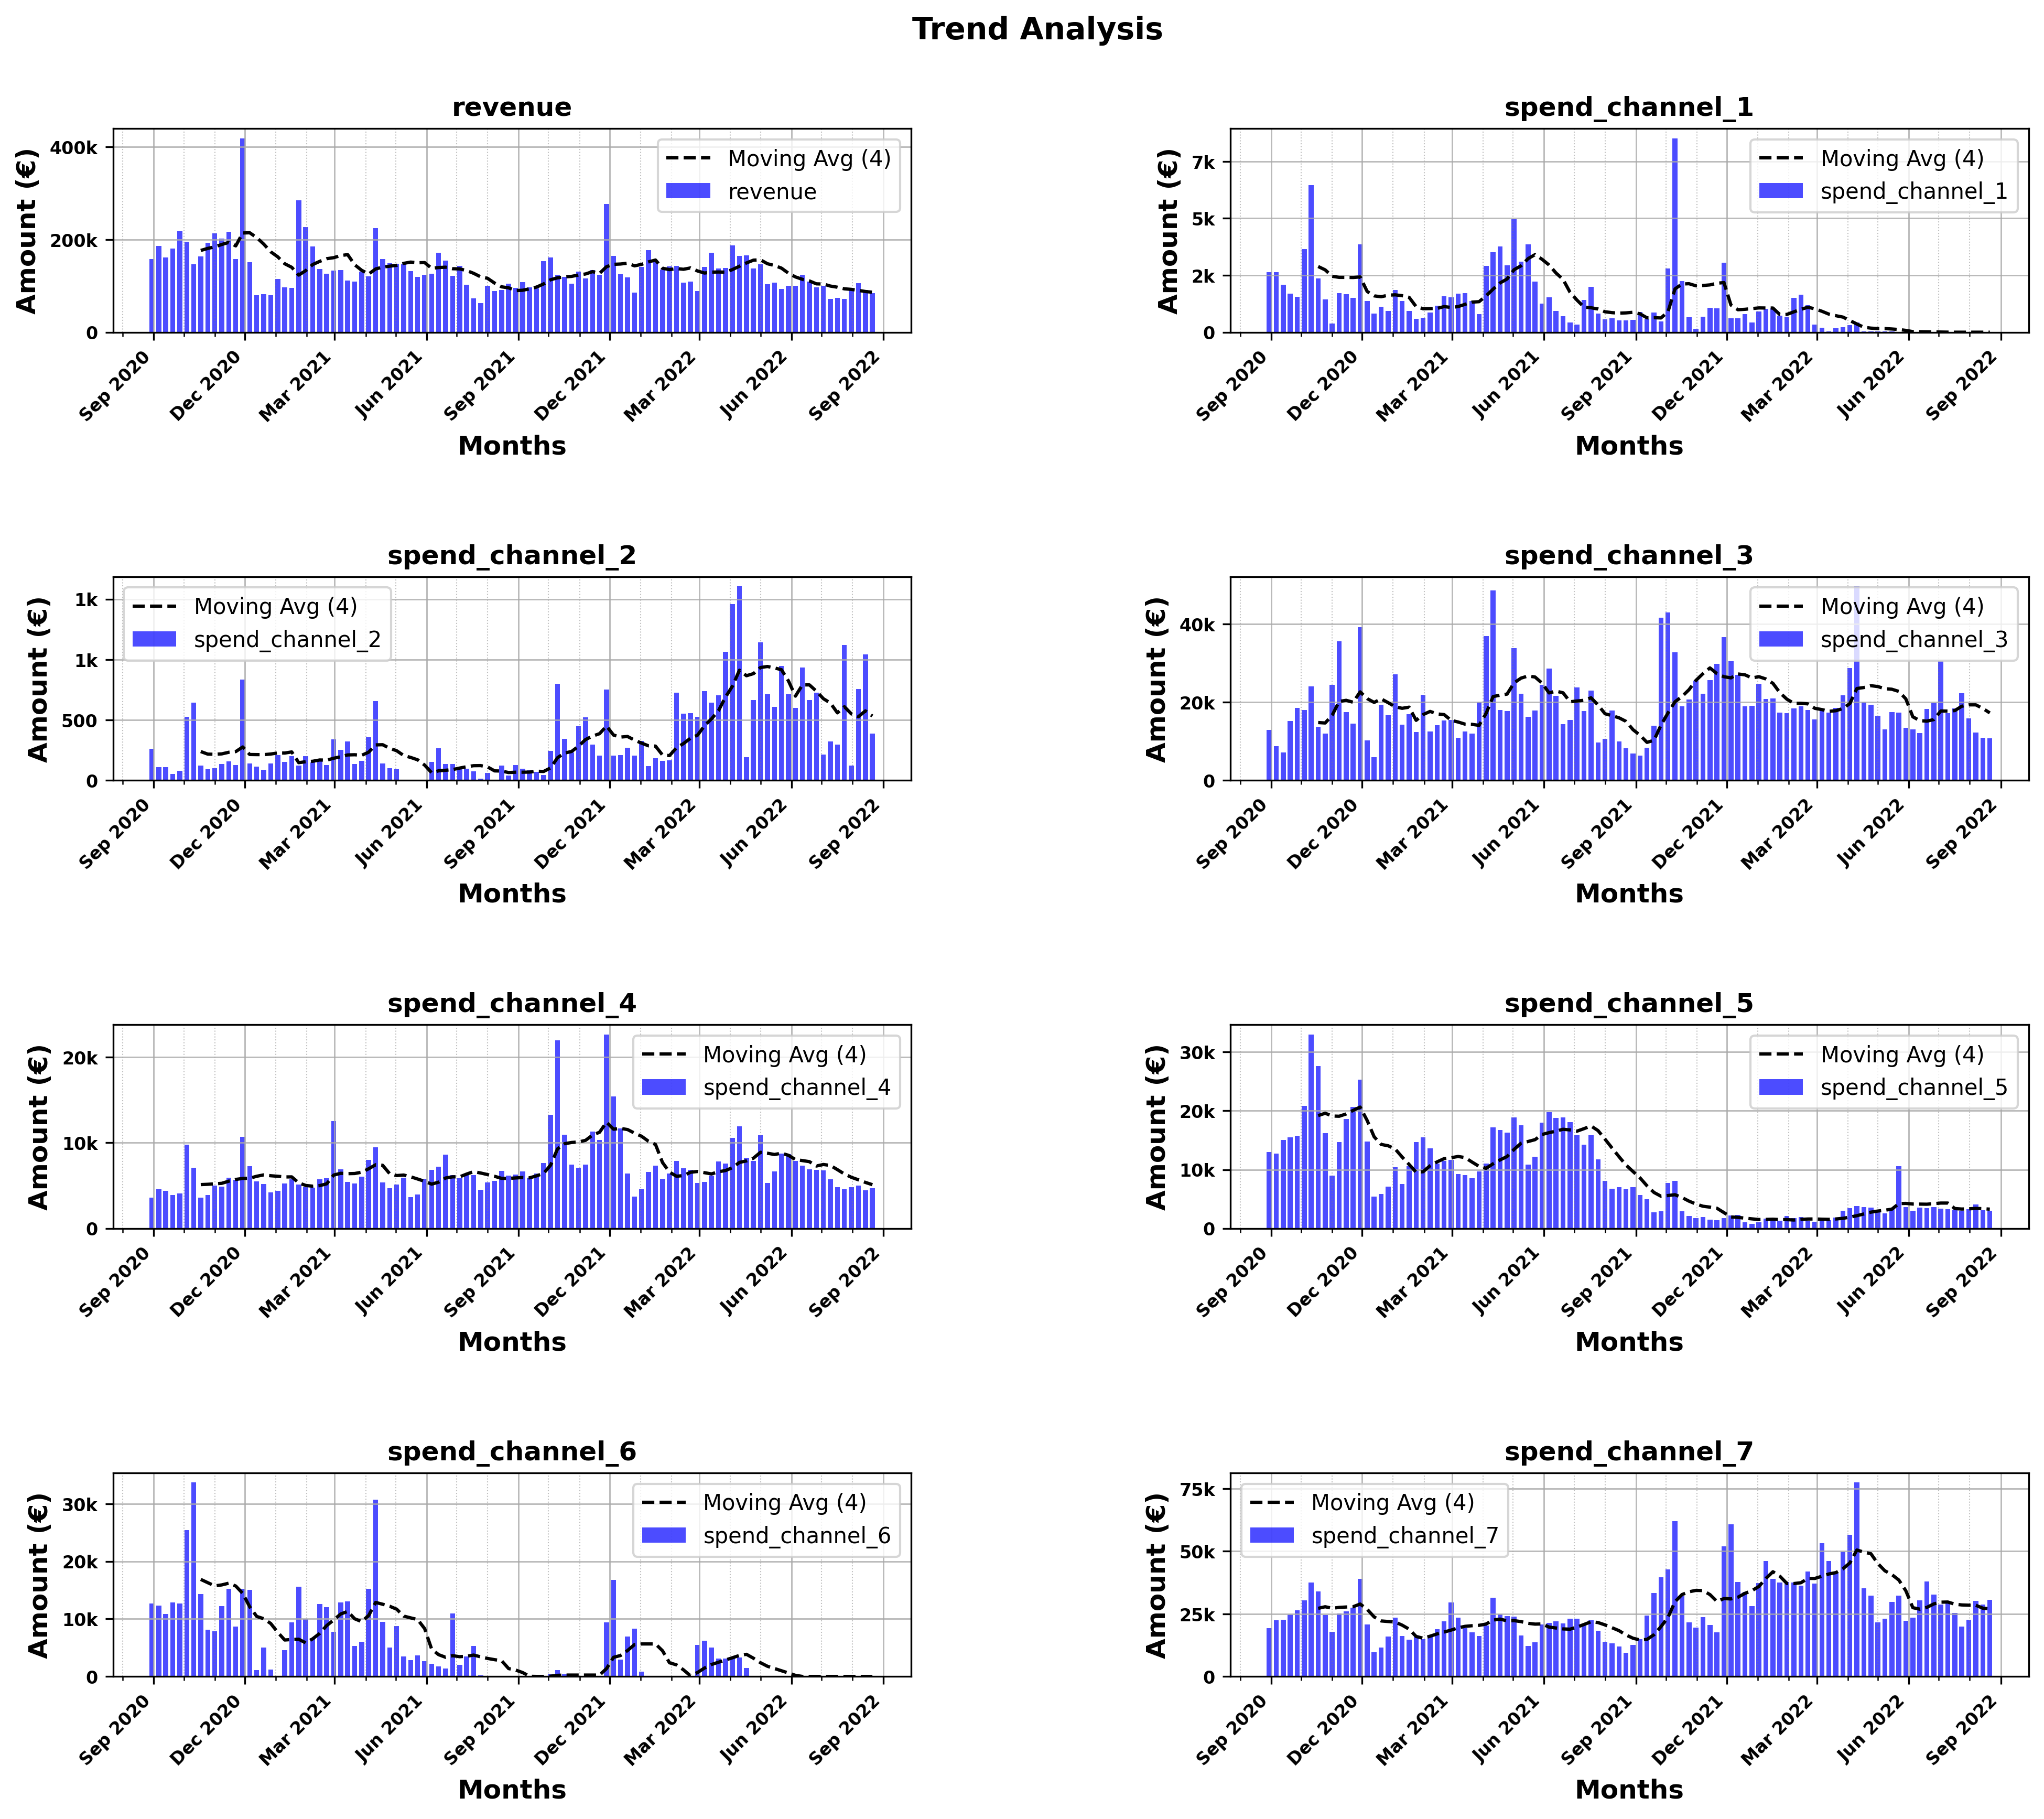

In [10]:
# Analyse Trends

columns_to_plot = df_1.loc[:,"revenue":"spend_channel_7"].columns.tolist() 

fig, axs = plt.subplots(4, 2, figsize=(14,12), dpi=300)
fig.suptitle("Trend Analysis",fontsize=14,fontweight='bold')
axs = axs.flatten()

for i, col in enumerate(columns_to_plot):
    ax = axs[i]
    
    ax.bar(df_1.index, df_1[col], width=5, label=col, alpha=0.7,color='blue')

    moving_avg = df_1[col].rolling(window=8).mean()
    
    ax.plot(df_1.index, moving_avg, linestyle='--', color='black', label='Moving Avg (4)')
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(3,6,9,12)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))

    ax.set_title(col, fontsize=12,fontweight='bold')
    ax.set_xlabel('Months',fontsize=12,fontweight='bold')
    ax.set_ylabel('Amount (€)', fontsize=12,fontweight='bold')
    
    # Format tick labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontweight='bold', fontsize=tick_fontsize)
    plt.setp(ax.get_yticklabels(), fontweight='bold', fontsize=tick_fontsize)
    
    # Set custom y-axis formatter for thousands
    ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    
    # Add grid lines for major and minor ticks
    ax.grid(which='major', linestyle='-', linewidth=0.7, color='darkgrey', alpha=0.8)
    ax.grid(which='minor', linestyle=':', linewidth=0.5, color='grey', alpha=0.5)
    
    ax.legend()

plt.subplots_adjust(left=0.08, right=0.95, top=0.92, bottom=0.1, hspace=1.2, wspace=0.4)
plt.show()


In [11]:
def geometric_adstock(x, alpha):
    """Apply geometric adstock to array x with decay factor alpha."""
    adx = np.zeros_like(x)
    adx[0] = x[0]
    for t in range(1, len(x)):
        adx[t] = x[t] + alpha * adx[t-1]  # carryover from prior period
    return adx


In [12]:
# Apply adstock with some assumed true alphas for simulation

weeks = np.arange(104)
spend_matrix = df_1.loc[:,"spend_channel_1":"spend_channel_7"]

true_alphas = [0.5, 0.1, 0.7, 0.3, 0.8, 0.2, 0.4]
adstock_matrix = np.column_stack([
    geometric_adstock(spend_matrix.iloc[:, i], alpha)
    for i, alpha in enumerate(true_alphas)
])

# revenue scaling
revenue_scaler = df_1['revenue'].mean()
df_1['scaled_revenue'] = df_1['revenue'] / revenue_scaler

# spend matrix scaling according to spend proportions
channel_means = spend_matrix.mean()
spend_matrix_scaled = spend_matrix / channel_means

### Control features

df_1['trend'] = weeks

# Assume df['revenue'] and df['start_of_week'] are available
sales = df_1['revenue'].values

# Detect peaks (spikes in sales) – tweak `distance` and `prominence` as needed
peaks, _ = find_peaks(sales, distance=4, prominence=5)  # 4 weeks apart minimum

# Reset index to integer values 
df_1 = df_1.reset_index(drop=True)  # ensures 0-based integer index

# Create an empty flag column
df_1['peak_flag'] = 0

# Mark detected peaks
df_1.loc[peaks, 'peak_flag'] = 1

# Final matrices
spend_matrix_scaled = spend_matrix_scaled[:].values
trend = df_1['trend'].values
peak_flag = df_1['peak_flag'].values
sales = df_1['scaled_revenue'].values

/var/folders/fw/xc82hx1j6jv0qphdn9jghnt40000gn/T/ipykernel_40827/358783357.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adx[0] = x[0]
/var/folders/fw/xc82hx1j6jv0qphdn9jghnt40000gn/T/ipykernel_40827/358783357.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adx[t] = x[t] + alpha * adx[t-1]  # carryover from prior period


In [18]:
# Model Set up
with pm.Model() as mmm_model:

    # Data blocks
    pm.Data("spend", spend_matrix_scaled)         # shape: (T, 7)
    pm.Data("trend", trend)                       # shape: (T,)
    pm.Data("peak_flag", peak_flag)               # shape: (T,)
    
    T = spend_matrix_scaled.shape[0]
    n_channels = spend_matrix_scaled.shape[1]
    L_max = 52  # max lag

    # Priors
    intercept = pm.Normal("intercept", mu=1, sigma=2)
    beta_trend = pm.Normal("beta_trend", mu=0, sigma=1)
    beta_peak = pm.Normal("beta_peak", mu=0, sigma=10)

    # ⬅️ Use channel_means for HalfNormal sigma priors
    beta_media = pm.HalfNormal("beta_media", sigma=channel_means.values, shape=n_channels)
    alpha_media = pm.Beta("alpha_media", alpha=1, beta=1, shape=n_channels)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Adstock
    media_contribs = []
    for i in range(n_channels):
        x_i = mmm_model["spend"][:, i]
        lagged = [at.concatenate([at.zeros(j), x_i[:-j]]) if j > 0 else x_i for j in range(L_max)]
        lagged_stack = at.stack(lagged)
        decay_weights = alpha_media[i] ** at.arange(L_max)
        adstock_i = at.dot(decay_weights, lagged_stack)
        media_contribs.append(beta_media[i] * adstock_i)

    total_media_effect = at.sum(at.stack(media_contribs), axis=0)
    
    trend_data = mmm_model["trend"]
    peak_flag_data = mmm_model["peak_flag"]
    control_effect = beta_trend * trend_data + beta_peak * peak_flag_data
    
    mu = intercept + control_effect + total_media_effect

    sales_obs = pm.Normal("sales_obs", mu=mu, sigma=sigma, observed=df_1['scaled_revenue'])

    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.9, random_seed=42, progressbar=True)

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    8             0.07        63           4.77 draws/s     0:06:58   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    4             0.06        63           4.77 draws/s     0:06:58   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.09        63           4.59 draws/s     0:07:15   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    1             0.08        31           4.54 draws/s     0:07:19   0:00:00

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 440 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.


AttributeError: module 'pymc' has no attribute 'set_tt_rng'

In [28]:
# Save model with posterior samples

az.to_netcdf(trace, "trace/trace.nc")            # ✅ Save

'trace/trace.nc'

In [29]:
# Save model as pkg

pm.save_trace(trace, dirrectory="models/model_pkg_1")

AttributeError: module 'pymc' has no attribute 'save_trace'

array([[<Axes: title={'center': 'beta_media'}>,
        <Axes: title={'center': 'beta_media'}>],
       [<Axes: title={'center': 'alpha_media'}>,
        <Axes: title={'center': 'alpha_media'}>]], dtype=object)

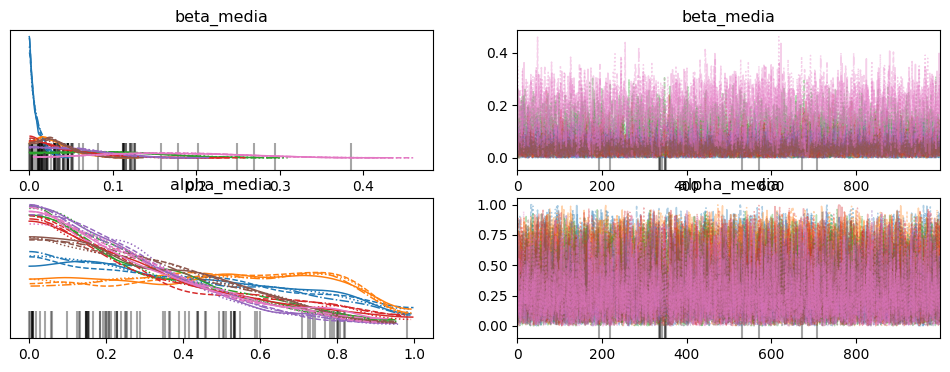

In [21]:
# Model Diagnostics

az.plot_trace(trace, var_names=['beta_media', 'alpha_media'])


In [22]:
az.summary(trace, var_names=['beta_media', 'alpha_media', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_media[0],0.009,0.008,0.000,0.025,0.000,0.000,2698.0,1822.0,1.0
beta_media[1],0.031,0.021,0.000,0.069,0.000,0.000,2524.0,1568.0,1.0
beta_media[2],0.097,0.059,0.000,0.196,0.001,0.001,2336.0,1136.0,1.0
beta_media[3],0.042,0.038,0.000,0.114,0.001,0.001,2945.0,2405.0,1.0
beta_media[4],0.054,0.037,0.000,0.117,0.001,0.001,2351.0,2069.0,1.0
beta_media[5],0.032,0.021,0.000,0.070,0.000,0.000,2361.0,1371.0,1.0
beta_media[6],0.173,0.077,0.034,0.310,0.002,0.001,2417.0,1948.0,1.0
alpha_media[0],0.396,0.266,0.000,0.847,0.004,0.003,3862.0,2342.0,1.0
alpha_media[1],0.472,0.262,0.023,0.875,0.005,0.003,2836.0,2283.0,1.0
alpha_media[2],0.276,0.219,0.000,0.685,0.004,0.003,3524.0,2513.0,1.0


In [27]:
with mmm_model:
    pm.model_to_graphviz(mmm_model)